<a href="https://colab.research.google.com/github/Rajitchandra/rajit/blob/master/inception_lesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file
import scipy
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.utils import class_weight
from keras import backend as K
from tensorflow.keras.preprocessing import image
import cv2
import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [ ]:
#dataset
!gdown --id 1TaA-NC1FyEvhZiMbYAfKiHSlcP5hSou5
#train_df
!gdown --id 1L3O8ODmBuha-lO3HalK5H9gDkAHvBwIo
#test_df
!gdown --id 1ZxQ3hvlDd5VpHOgtaFcUJXY37c3YA1gi
#valid_df
!gdown --id 1qOb7HDKlphQu2m_JcOIEtQvch8qX6Vbd

Downloading...
From: https://drive.google.com/uc?id=1TaA-NC1FyEvhZiMbYAfKiHSlcP5hSou5
To: /content/ISIC2018_Task3_Training_Input.zip
2.77GB [00:58, 47.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L3O8ODmBuha-lO3HalK5H9gDkAHvBwIo
To: /content/train_df.csv
100% 316k/316k [00:00<00:00, 42.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZxQ3hvlDd5VpHOgtaFcUJXY37c3YA1gi
To: /content/test_df.csv
100% 122k/122k [00:00<00:00, 45.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qOb7HDKlphQu2m_JcOIEtQvch8qX6Vbd
To: /content/valid_df.csv
100% 13.6k/13.6k [00:00<00:00, 24.8MB/s]


In [3]:
!unzip /content/ISIC2018_Task3_Training_Input.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029322.jpg  
  inflating: /content/ISIC2018_Task3_Training_Input/ISIC_0029323.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029324.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029325.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029326.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029327.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029328.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029329.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029330.jpg  
  inflating: /content/ISIC2018_Task3_Training_Input/ISIC_0029331.jpg  
  inflating: /content/ISIC2018_Task3_Training_Input/ISIC_0029332.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029333.jpg  
 extracting: /content/ISIC2018_Task3_Training_Input/ISIC_0029334.jpg  
  inflating: /content/ISIC

In [4]:
!rm -rf '/content/ISIC2018_Task3_Training_Input.zip'

In [9]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, seed=1, target_width = 320, target_height = 320):

    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
         rotation_range=90,
        horizontal_flip=True,
        zoom_range=[0.5,1.0])
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_width,target_height))
    
    return generator

In [5]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
valid_df = pd.read_csv('valid_df.csv')

In [11]:
def get_valid_and_test_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, 
                                 target_width = 320, target_height = 320):
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="images", 
        y_col=classes, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_width, target_height))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_width,target_height))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_width,target_height))
    return valid_generator, test_generator

In [12]:
train_df.head()

,Melanoma,Nevs,Carcinoma,Actinic,Seborrheic,Dermatofibroma,Vascular,images
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0024477.jpg
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ISIC_0031236.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034117.jpg
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0025767.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0033068.jpg


In [13]:
classes = ['Actinic', 'Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevs', 'Seborrheic', 'Vascular']

In [14]:
IMAGE_DIR = "/content/ISIC2018_Task3_Training_Input"
train_generator = get_train_generator(train_df, IMAGE_DIR, 'images', classes)
valid_generator, test_generator= get_valid_and_test_generator(valid_df, test_df, train_df, IMAGE_DIR, "images", classes)

getting train generator...
Found 7010 validated image filenames.
getting train and valid generators...
Found 7010 validated image filenames.
Found 301 validated image filenames.
Found 2704 validated image filenames.


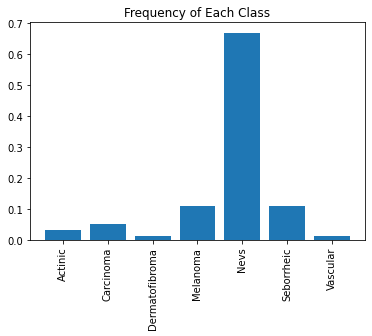

In [15]:
plt.xticks(rotation=90)
plt.bar(x=classes, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [16]:
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

In [17]:
# create the base pre-trained model
base_model = InceptionV3(weights = 'imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss = FocalLoss(alpha=1))

87924736/87910968 [==============================] - 2s 0us/step


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
history = model.fit(train_generator, validation_data= valid_generator, epochs = 30)

Epoch 1/30
220/220 [==============================] - 376s 2s/step - loss: 0.5315 - val_loss: 1.0118
Epoch 2/30
220/220 [==============================] - 321s 1s/step - loss: 0.4548 - val_loss: 1.2925
Epoch 3/30
220/220 [==============================] - 318s 1s/step - loss: 0.4299 - val_loss: 1.1099
Epoch 4/30
220/220 [==============================] - 316s 1s/step - loss: 0.3869 - val_loss: 0.8974
Epoch 5/30
220/220 [==============================] - 316s 1s/step - loss: 0.3732 - val_loss: 0.9794
Epoch 6/30
220/220 [==============================] - 314s 1s/step - loss: 0.3731 - val_loss: 0.8307
Epoch 7/30
220/220 [==============================] - 312s 1s/step - loss: 0.3346 - val_loss: 1.4509
Epoch 8/30
220/220 [==============================] - 311s 1s/step - loss: 0.3295 - val_loss: 0.9409
Epoch 9/30
220/220 [==============================] - 310s 1s/step - loss: 0.3220 - val_loss: 0.9538
Epoch 10/30
220/220 [==============================] - 307s 1s/step - loss: 0.2939 - val_lo

In [20]:
model.save("model_inception.h5")

In [21]:
predicted_values = model.predict(test_generator, steps = len(test_generator))

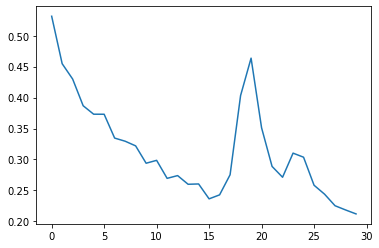

In [22]:
plt.plot(history.history['loss'])

In [23]:
def get_roc_curve(labels, predicted_values, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_values[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


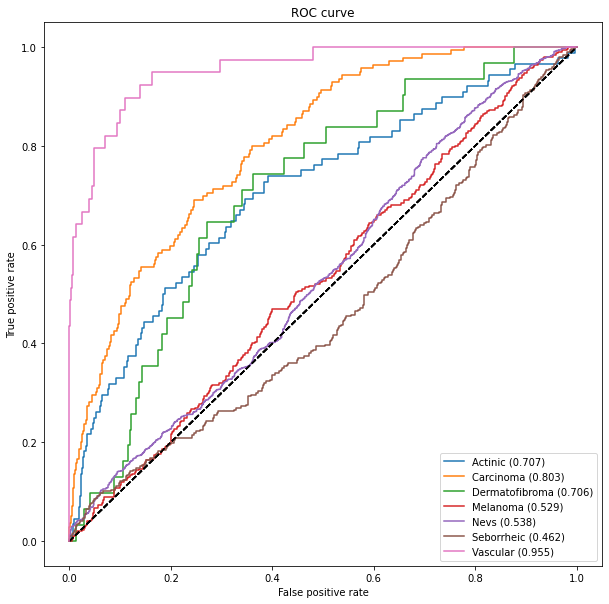

In [24]:
auc_rocs = get_roc_curve(classes, predicted_values, test_generator)

In [25]:
df = pd.read_csv("train_df.csv")
# only show the labels with top 4 AUC
labels_to_plot = np.take(classes, np.argsort(auc_rocs)[::-1])

In [26]:
def norm_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["images"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

In [27]:
def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = norm_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

In [28]:
def compute_gradcam(model, img, image_dir, df, labels, selected_labels, layer_name='batch_normalization_93',
                   W = 320, H=320):
    
    preprocessed_image = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_image)
    
    ##############################
    print("Loading original image")
    plt.figure(figsize=(25, 10))
    plt.subplot(291)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
    ##############################
    
    
    layer_name='batch_normalization_93'
    conv_output = model.get_layer(layer_name).output
    gradModel = Model(
                inputs=[model.inputs],
                outputs=[conv_output,model.output])
    
    j = 2
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")

            cls = 0 # specific class output probability
            with tf.GradientTape() as tape:
                (convOutputs, pred) = gradModel(preprocessed_image)
                loss = pred[:, cls]
            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)
            
            output, grads_val = convOutputs[0, :], grads[0, :, :, :] #no need of batch information

            weights = np.mean(grads_val, axis=(0, 1))
            cam = np.dot(output, weights)

            # Process CAM
            cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
            cam = np.maximum(cam, 0)
            gradcam = cam / cam.max()
            
            ###############################
            plt.subplot(191 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),cmap='gray')
            
            #value = np.array(min(0.5, predictions[0][i])).reshape(1,1)
            value = min(0.5, predictions[0][i])
            value = np.repeat(value,W*H).reshape(W,H)
            plt.imshow(gradcam, cmap='jet', alpha=value)
            j += 1
            #################################


Loading original image
Generating gradcam for class Actinic


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Generating gradcam for class Carcinoma
Generating gradcam for class Dermatofibroma
Generating gradcam for class Melanoma
Generating gradcam for class Nevs
Generating gradcam for class Seborrheic
Generating gradcam for class Vascular


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


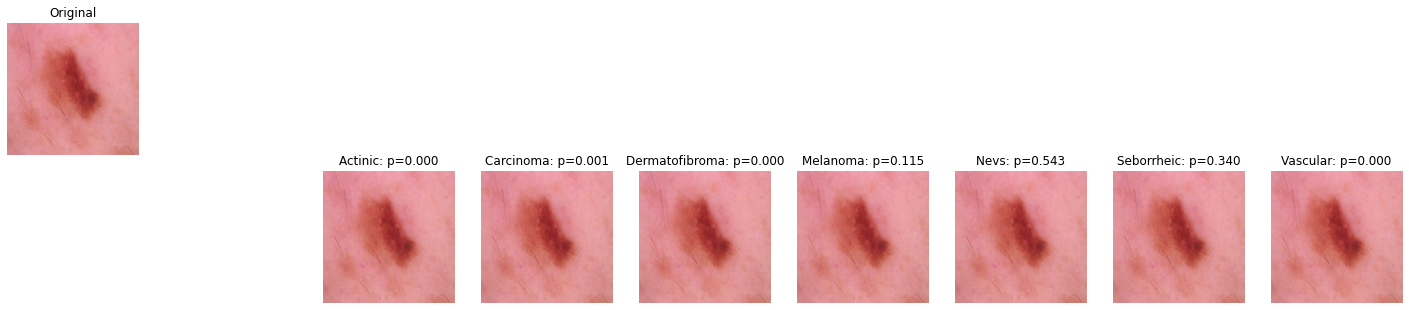

In [29]:
IMAGE_DIR = "ISIC2018_Task3_Training_Input/"
compute_gradcam(model, 'ISIC_0024622.jpg', IMAGE_DIR, df, classes, labels_to_plot)